<a href="https://colab.research.google.com/github/alvroble/NetConfigLens/blob/main/NCL_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial imports and variables assignment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
path_files ='/content/drive/MyDrive/Colab Notebooks/NetConfigLens'
path_config_files_train = '/content/drive/MyDrive/Colab Notebooks/NetConfigLens/train_configs'
path_config_files_val = '/content/drive/MyDrive/Colab Notebooks/NetConfigLens/val_configs'
path_model='/content/drive/MyDrive/Colab Notebooks/NetConfigLens/NCL_GPT2'

In [ ]:
!pip install -q transformers
!pip install -q tokenizer
!pip install -q gensim
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from transformers import GPT2Tokenizer, GPT2Config, TFGPT2LMHeadModel
from transformers import WEIGHTS_NAME, CONFIG_NAME
from pathlib import Path
import os
from gensim.corpora import WikiCorpus
from tokenizers import Tokenizer
from tokenizers.models import BPE,WordLevel
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.normalizers import NFD, Sequence, Lowercase
from tokenizers.trainers import BpeTrainer,WordLevelTrainer
from tokenizers.pre_tokenizers import ByteLevel, CharDelimiterSplit, Whitespace
from tokenizers.pre_tokenizers import Sequence as PreSequence
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer as WordTokenizer,tokenizer_from_json
import json
import pandas as pd
import random
import torch
import numpy as np

In [ ]:
test_samples = 10
configuration_start_point = '!'
max_dictionary_size=50000
top_n_probabilities = 3
probability_threshold = 3
word_variability_threshold = 10
test_file = 'config_PE-100_WithErrors.cfg'
test_file_loc = 'config_PE-100_WithErrors_Loc.cfg'
context_before = 20
temperature = 1.0
tokenizer_file = "tokenizer-pe.json"
total_positives = 70

#Data preprocessing

First, text data is loaded from Google Drive

In [ ]:
train_configs = [f for f in listdir(path_config_files_train) if (isfile(join(path_config_files_train, f)))]
val_configs = [f for f in listdir(path_config_files_val) if (isfile(join(path_config_files_val, f)))]

Auxiliar functions are created for data preprocessing

In [ ]:
def find_config_start(config_lines, start_sequence):
  i=0
  config_found = np.False_
  while not config_found:
    if start_sequence in config_lines[i]:
      config_found = True
      config_index = i+1
    else:
      i+=1
  return config_index

In [ ]:
def get_config_lines(config_file):
  file_handle = open(config_file, 'r')
  config_lines = file_handle.readlines()
  config_index = find_config_start(config_lines,configuration_start_point)
  return config_lines[config_index:]


In [ ]:
def build_corpus(train_configs,path):
  corpus = []
  for config_file in train_configs:
    #print('Config:',config_file)
    config_lines = get_config_lines(join(path,config_file))
    for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
  return corpus

In [ ]:
def build_corpus_gen(train_configs,path):
  for config_file in train_configs:
    corpus = []
    #print('Config:',config_file)
    config_lines = get_config_lines(join(path,config_file))
    for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
    yield corpus

##Tokenizer - Option 1. Train from text

In [ ]:
def build_tokenizer(train_configs,path):
  tokenizer = WordTokenizer(filters='',oov_token='OOV',num_words=max_dictionary_size)
  tokenizer.fit_on_texts(build_corpus_gen(train_configs,path))
  total_words = len(tokenizer.word_index) + 1
  print(total_words)
  return tokenizer

In [ ]:
wtokenizer = build_tokenizer(train_configs,path_config_files_train)

1770


##Tokenizer - Option 2. Load from pretrained

In [ ]:
with open(join(path_model,tokenizer_file)) as f:
    data = json.load(f)
    wtokenizer = tokenizer_from_json(data)

In [ ]:
total_words = len(wtokenizer.word_index)+1
dictionary_size = min(total_words,max_dictionary_size)

In [ ]:
dictionary_size

1771

##Text preprocessing and dataset building

In [ ]:
BATCH_SIZE = 128

In [ ]:
corpus_train = build_corpus(train_configs,path_config_files_train)

input_ids = []
for item in corpus_train:
  input_ids += wtokenizer.texts_to_sequences([item])[0]

# Training dataset
inputs = input_ids[:-1]
labels = input_ids[1:]

dataset_train = tf.data.Dataset.from_tensor_slices((inputs, labels))
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

print("Done creating dataset for training")

Done creating dataset for training


In [ ]:
corpus_val = build_corpus(val_configs,path_config_files_val)

input_ids_val = []
for item in corpus_val:
  input_ids_val += wtokenizer.texts_to_sequences([item])[0]

# Validation dataset
inputs_val = input_ids_val[:-1]
labels_val = input_ids_val[1:]

dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val, labels_val))
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)
print("Done creating dataset for validation")

Done creating dataset for validation


Word variability analysis

In [ ]:
total_words = len(wtokenizer.word_index)+1
total_next_words = []
for w in range(total_words):
  total_next_words.append([])
total_nexts = [0 for i in range(total_words)]

for config in tqdm(train_configs):
  corpus = []
  config_lines = get_config_lines(join(path_config_files_train,config))
  for i in range(len(config_lines)):
    corpus += config_lines[i].lower().split()
  for i in range(len(corpus)-1):
    current_token = wtokenizer.texts_to_sequences([corpus[i]])[0][0]
    next_token = wtokenizer.texts_to_sequences([corpus[i+1]])[0][0]
    current_token_nexts = total_next_words[current_token]
    if next_token not in current_token_nexts:
      total_next_words[current_token].append(next_token)
      total_nexts[current_token]+=1

100%|██████████| 90/90 [00:37<00:00,  2.37it/s]


#Model creation and training

In [ ]:
config = GPT2Config(
    vocab_size=dictionary_size,
    bos_token_id=None,
    eos_token_id=None
)

In [ ]:
model = TFGPT2LMHeadModel(config)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])

In [ ]:
num_epoch = 10
history = model.fit(dataset_train, epochs=num_epoch, validation_data=dataset_val)

Epoch 1/10
490/490 [==============================] - 69s 75ms/step - loss: 2.6828 - accuracy: 0.5271 - val_loss: 0.9996 - val_accuracy: 0.7718
Epoch 2/10
490/490 [==============================] - 33s 67ms/step - loss: 0.7545 - accuracy: 0.8385 - val_loss: 0.6671 - val_accuracy: 0.8148
Epoch 3/10
490/490 [==============================] - 33s 67ms/step - loss: 0.4948 - accuracy: 0.8919 - val_loss: 0.5439 - val_accuracy: 0.8670
Epoch 4/10
490/490 [==============================] - 33s 68ms/step - loss: 0.3683 - accuracy: 0.9250 - val_loss: 0.4273 - val_accuracy: 0.9207
Epoch 5/10
490/490 [==============================] - 34s 69ms/step - loss: 0.2870 - accuracy: 0.9449 - val_loss: 0.3625 - val_accuracy: 0.9427
Epoch 6/10
490/490 [==============================] - 33s 68ms/step - loss: 0.2419 - accuracy: 0.9533 - val_loss: 0.3390 - val_accuracy: 0.9479
Epoch 7/10
490/490 [==============================] - 33s 67ms/step - loss: 0.2165 - accuracy: 0.9567 - val_loss: 0.3455 - val_accuracy:

Training results for loss and accuracy

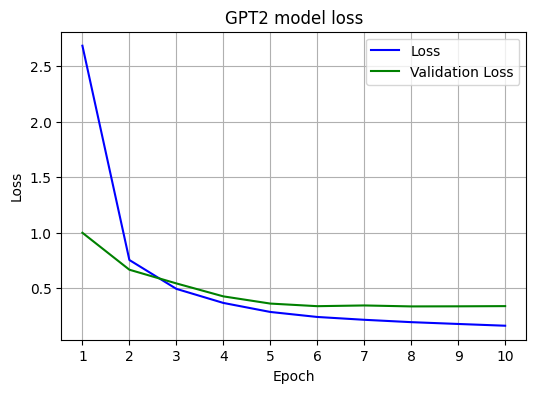

In [ ]:
# Creating the plot
plt.figure(figsize=(6, 4))
xval = np.arange(1,num_epoch+1)

plt.plot(xval,history.history["loss"], label='Loss', color='blue')
plt.plot(xval,history.history["val_loss"], label='Validation Loss', color='green')

plt.xticks(xval)

plt.title('GPT2 model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.grid(True)

plt.show()

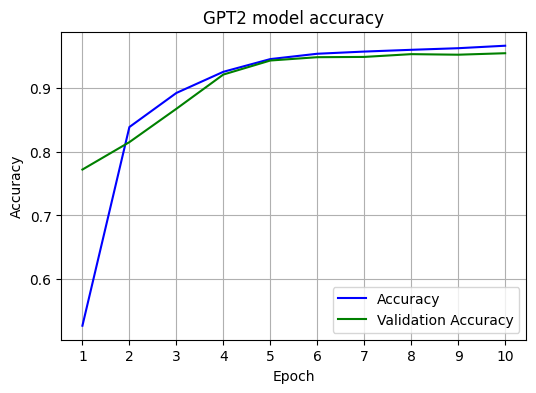

In [ ]:
plt.figure(figsize=(6, 4))
xval = np.arange(1,num_epoch+1)

plt.plot(xval,history.history["accuracy"], label='Accuracy', color='blue')
plt.plot(xval,history.history["val_accuracy"], label='Validation Accuracy', color='green')

plt.xticks(xval)

plt.title('GPT2 model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.grid(True)

plt.show()

The model is saved

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(path_model, WEIGHTS_NAME)
output_config_file = os.path.join(path_model, CONFIG_NAME)

model.save_pretrained(path_model)
model_to_save.config.to_json_file(output_config_file)


#Error search algorithm

First, trained model can be loaded from previous checkpoint

In [ ]:
model = TFGPT2LMHeadModel.from_pretrained(path_model)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/NetConfigLens/NCL_GPT2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Anomaly detection function. If it's used for ROC curve creation, softmax is avoided

In [ ]:
def compute_config_anomaly_vector(config_file, model, tokenizer,context_before=context_before,roc=False):
  text = build_corpus([config_file],path_files)
  input_ids = []
  for item in text:
    input_ids += wtokenizer.texts_to_sequences([item])[0]
  y_probability = []
  y_recommended = []
  max_prob = 20 if roc else 1770
  for i in tqdm(range(len(input_ids)-context_before-1)):
    # Obtain the logits for the next word
    logits = model(tf.convert_to_tensor(input_ids[i:i+context_before+1])).logits
    logits_vector = logits[:, -1, :] / temperature if roc else tf.nn.softmax(logits[:, -1, :] / temperature)
    # Compute the top N probabilities and their average probability
    temp = -np.partition(logits_vector,top_n_probabilities) if roc else np.partition(logits_vector,top_n_probabilities)
    y_pred_average = np.mean(temp[:top_n_probabilities])
    #print(y_pred_average)
    # Compute the actual probability from the next token in the input text
    y_pred_prob = logits_vector[:,input_ids[i+context_before+1]].numpy()[0]
    # Get the recommended token
    y_recom = np.argmax(logits_vector)
    # Get the variability for the actual last word and compute probabilities
    variability = total_nexts[input_ids[i+context_before]]
    if variability > word_variability_threshold:
      probability = max_prob
    else:
      probability = y_pred_prob/y_pred_average
    y_probability.append(probability)
    y_recommended.append(y_recom)
  return y_probability, y_recommended

#Tests for error searching

In [ ]:
context_before=20
y_probability,y_recommended = compute_config_anomaly_vector(join(path_files,test_file),model,wtokenizer,context_before=context_before)

100%|██████████| 676/676 [02:23<00:00,  4.70it/s]


y_probability is a vector of the same length as the text in words, and it indicates probability values for error detection.

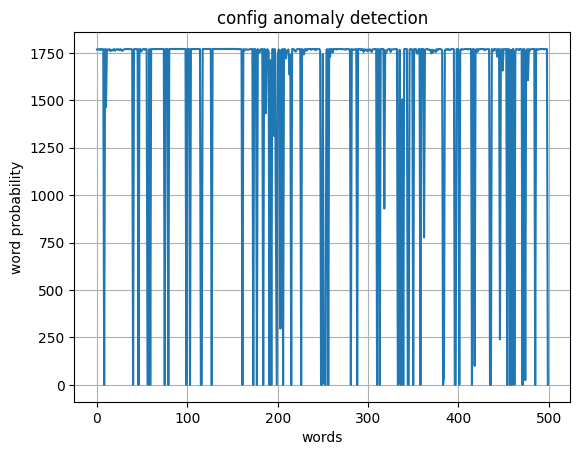

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_probability[0:500])

ax.set(xlabel='words', ylabel='word probability',
       title='config anomaly detection')
ax.grid()
plt.show()

Lowest values of probability are considered error, as shown in this histogram:

(array([ 73.,   3.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   2.,   1.,   0.,   3.,   4., 579.]),
 array([2.10618091e-04, 5.90260866e+01, 1.18051963e+02, 1.77077838e+02,
        2.36103714e+02, 2.95129590e+02, 3.54155466e+02, 4.13181342e+02,
        4.72207218e+02, 5.31233094e+02, 5.90258970e+02, 6.49284846e+02,
        7.08310722e+02, 7.67336598e+02, 8.26362474e+02, 8.85388350e+02,
        9.44414226e+02, 1.00344010e+03, 1.06246598e+03, 1.12149185e+03,
        1.18051773e+03, 1.23954361e+03, 1.29856948e+03, 1.35759536e+03,
        1.41662123e+03, 1.47564711e+03, 1.53467299e+03, 1.59369886e+03,
        1.65272474e+03, 1.71175061e+03, 1.77077649e+03]),
 <BarContainer object of 30 artists>)

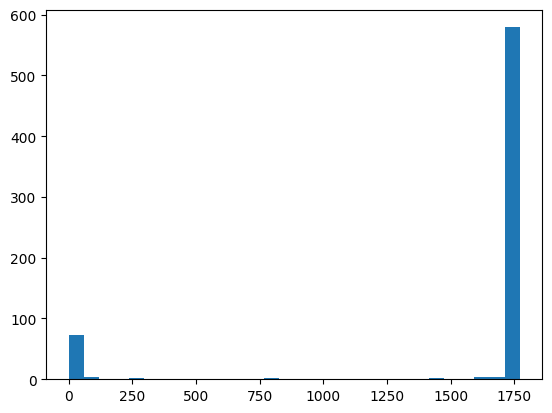

In [ ]:
fig, ax = plt.subplots()
ax.hist(y_probability, bins=30)

In [ ]:
probability_threshold = 7.1
#probability_threshold = 10
def display_config_anomalies(config_file,model,tokenizer,y_probability=None,y_recommended=None,config_file_loc=None,context_before=context_before):
  if y_probability==None and y_recommended==None:
    y_probability,y_recommended = compute_config_anomaly_vector(config_file,model,tokenizer,context_before)
  config_lines = get_config_lines(config_file)
  corpus = []
  for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
  # Corpus with error locs for confusion matrix
  if config_file_loc is not None:
    config_lines_loc = get_config_lines(config_file_loc)
    corpus_loc = []
    for i in range(len(config_lines_loc)):
        corpus_loc += config_lines_loc[i].lower().split()
  # Probability masking
  y_words = corpus[context_before+1:]
  probability_mask = np.array(y_probability) > probability_threshold
  print('Number of anomalies detected:',(len(y_words)-np.sum(probability_mask)))
  colored_config = ''
  false_positives = 0
  true_positives = 0
  total_words = len(corpus)
  word_index = 0
  for w in range(len(config_lines)):
    tokenized_line = config_lines[w].split()
    for item in tokenized_line:
      if word_index>=(context_before+1):
        if probability_mask[word_index-context_before-1]:
          if corpus_loc[word_index]=="<err>":
            colored_config += '\033[96m '+ item
          else:
            colored_config += '\033[92m '+ item
        else:
          if config_file_loc is not None:
            if corpus_loc[word_index]=="<err>":
              colored_config += '\033[91m '+ item + ' --> (expected: '+repr(wtokenizer.sequences_to_texts([[y_recommended[word_index-context_before-1]]])[0])+')'
              true_positives+=1
            else:
              colored_config += '\033[95m '+ item + ' --> (expected: '+repr(wtokenizer.sequences_to_texts([[y_recommended[word_index-context_before-1]]])[0])+')'
              false_positives+=1
      else:
          colored_config += '\033[94m '+ item
      word_index += 1
    colored_config += '\n'

  print(colored_config)
  if config_file_loc is not None:
    print(f"\033[93mTrue positives: {true_positives}")
    print(f"\033[93mFalse positives: {false_positives}")
    print(f"\033[93mTotal elements: {total_words}")
  return y_words

Given a probability threshold, errors can be found and the text can be reconstructed. Color code:

$\color{red}{\text{True positives}}$

$\color{magenta}{\text{False positives}}$

$\color{#00FFFF}{\text{False negatives}}$

$\color{#4D3AFF}{\text{Initial text, not applicable}}$

In [ ]:
y_words = display_config_anomalies(join(path_files,test_file),model,wtokenizer,y_probability,y_recommended,config_file_loc=join(path_files,test_file_loc))

Number of anomalies detected: 68
 !Image: Copyright (C) 2020 your favorite vendor. All rights reserved
 !Image: Software Product: IOS-XR, Version: 7.6R3
 !Image: Hardware Model: ASR
 !Image: Software Feature Code: SP
 !Image: System Configuration Code: S5 --> (expected: 's3')
 !Image: Package Configuration Code: P4
 !Image: Software Baseline Version: 2.3.5
 !Image: Installation Information:
 !Image: Image Filename: IOS-XR-7-6-R-3
 !Image: ONIE SysInfo: x86_64-accton_asr7736_64x-r0
 !
 !
 !
 !
 !
 !
 ! Software version: IOS-XR 7.11.1 --> (expected: '7.6r3')
 !
 !
 logging level cml 4 --> (expected: '5')
 !
 service password-encryption
 !
 disable confirmation-dialog
 !
 no logging monitor --> (expected: 'console')
 no --> (expected: 'logging') logging monitor --> (expected: 'level')
 logging level nsm 5
 logging level rip 5
 logging level ripng 5
 logging level ospf 4 --> (expected: '5')
 logging level ospf6 4 --> (expected: '5')
 logging level isis 5
 logging level hostp 5
 logging lev

##Test 1. Test for different context lengths

In [ ]:
probability_threshold = 7.1
#probability_threshold = 10
def get_config_anomalies(config_file,model,tokenizer,y_probability=None,y_recommended=None,config_file_loc=None,context_before=context_before):
  if y_probability==None and y_recommended==None:
    y_probability,y_recommended = compute_config_anomaly_vector(config_file,model,tokenizer,context_before)
  config_lines = get_config_lines(config_file)
  corpus = []
  for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
  # Corpus with error locs for confusion matrix
  if config_file_loc is not None:
    config_lines_loc = get_config_lines(config_file_loc)
    corpus_loc = []
    for i in range(len(config_lines_loc)):
        corpus_loc += config_lines_loc[i].lower().split()
  # Probability masking
  y_words = corpus[context_before+1:]
  probability_mask = np.array(y_probability) > probability_threshold
  print('Number of anomalies detected:',(len(y_words)-np.sum(probability_mask)))
  colored_config = ''
  false_positives = 0
  true_positives = 0
  total_words = len(corpus)
  word_index = 0
  for w in range(len(config_lines)):
    tokenized_line = config_lines[w].split()
    for item in tokenized_line:
      if word_index>=(context_before+1):
        if probability_mask[word_index-context_before-1]:
          if corpus_loc[word_index]=="<err>":
            colored_config += '\033[94m '+ item
          else:
            colored_config += '\033[92m '+ item
        else:
          colored_config += '\033[91m '+ item + ' --> (expected: '+repr(wtokenizer.sequences_to_texts([[y_recommended[word_index-context_before-1]]])[0])+')'
          if config_file_loc is not None:
            if corpus_loc[word_index]=="<err>":
              true_positives+=1
            else:
              false_positives+=1
      else:
          colored_config += '\033[94m '+ item
      word_index += 1
    colored_config += '\n'

  return true_positives, false_positives, total_words

In [ ]:
context_list = [10,20,30,40,50,60,70,80,90,100]
fp_list = []
tp_list = []
tw_list = []

for context in context_list:
  tp,fp,tw = get_config_anomalies(join(path_files,test_file),model,wtokenizer,config_file_loc=join(path_files,test_file_loc),context_before=context)
  tp_list.append(tp)
  fp_list.append(fp)
  tw_list.append(tw)

100%|██████████| 686/686 [02:45<00:00,  4.15it/s]


Number of anomalies detected: 68


100%|██████████| 676/676 [02:54<00:00,  3.87it/s]


Number of anomalies detected: 68


100%|██████████| 666/666 [02:55<00:00,  3.80it/s]


Number of anomalies detected: 65


100%|██████████| 656/656 [02:35<00:00,  4.22it/s]


Number of anomalies detected: 68


100%|██████████| 646/646 [02:10<00:00,  4.96it/s]


Number of anomalies detected: 70


100%|██████████| 636/636 [02:07<00:00,  4.98it/s]


Number of anomalies detected: 67


100%|██████████| 626/626 [02:05<00:00,  4.99it/s]


Number of anomalies detected: 67


100%|██████████| 616/616 [02:08<00:00,  4.78it/s]


Number of anomalies detected: 65


100%|██████████| 606/606 [02:02<00:00,  4.96it/s]


Number of anomalies detected: 63


100%|██████████| 596/596 [02:01<00:00,  4.91it/s]

Number of anomalies detected: 60


In [ ]:
print(tp_list)
print(fp_list)
print(tw_list)

[54, 56, 54, 55, 55, 54, 52, 52, 51, 49]
[14, 12, 11, 13, 15, 13, 15, 13, 12, 11]
[697, 697, 697, 697, 697, 697, 697, 697, 697, 697]


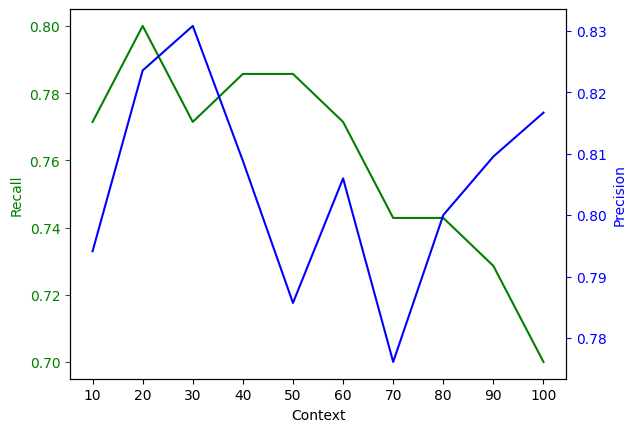

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x = context_list
y1 = tp_list
y2 = fp_list

fn_list = np.repeat(total_positives,len(x))-np.array(tp_list)
recall = np.divide(tp_list, tp_list+fn_list)
precision = np.array(tp_list)/(np.array(tp_list)+np.array(fp_list))

# Create two subplots
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # Creates a second y-axis on the right

# Plot on the first subplot
ax1.plot(x, recall, 'g-')
ax1.set_xlabel('Context')
ax1.set_ylabel('Recall', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(x)

# Plot on the second subplot
ax2.plot(x, precision, 'b-')
ax2.set_ylabel('Precision', color='b')
ax2.tick_params('y', colors='b')

# Show the plot
plt.show()


The best overall result of recall and precision is obtained for 20 words of previous context.

##Test 2. ROC curves for the best performance

In [ ]:
def get_roc_values(config_file,model,tokenizer,probability_threshold,y_probability=None,y_recommended=None,config_file_loc=None):
  if y_probability==None and y_recommended==None:
    y_probability,y_recommended = compute_config_anomaly_vector(config_file,model,tokenizer,roc=True)
  config_lines = get_config_lines(config_file)
  corpus = []
  for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
  # Corpus with error locs for confusion matrix
  if config_file_loc is not None:
    config_lines_loc = get_config_lines(config_file_loc)
    corpus_loc = []
    for i in range(len(config_lines_loc)):
        corpus_loc += config_lines_loc[i].lower().split()
  # Probability masking
  y_words = corpus[context_before+1:]
  probability_mask = np.array(y_probability) > probability_threshold
  #print('Number of anomalies detected:',(len(y_words)-np.sum(probability_mask)))
  expected_words = []
  false_positives = 0
  true_positives = 0
  total_words = len(corpus)
  word_index = 0
  for w in range(len(config_lines)):
    tokenized_line = config_lines[w].split()
    for item in tokenized_line:
      if word_index>=(context_before+1):
        if not probability_mask[word_index-context_before-1]:
          expected_words.append(wtokenizer.sequences_to_texts([[y_recommended[word_index-context_before-1]]])[0])
          if config_file_loc is not None:
            if corpus_loc[word_index]=="<err>":
              true_positives+=1
            else:
              false_positives+=1
      word_index += 1

  if config_file_loc is not None:
    positives = 70
    true_negatives = total_words-true_positives-false_positives
    false_negatives = positives-true_positives
    tpr = true_positives/(true_positives+false_negatives)
    fpr = false_positives/(false_positives+true_negatives)
    tnr = true_negatives/(false_positives+true_negatives)
    fnr = false_negatives/(true_positives+false_negatives)
    precision = true_positives / (true_positives + false_positives) if true_positives!=0 and false_positives!=0 else None
    recall = true_positives / (true_positives + false_negatives)
  return tpr,fpr,tnr,fnr,precision,recall,y_probability,y_recommended

100%|██████████| 676/676 [02:21<00:00,  4.78it/s]


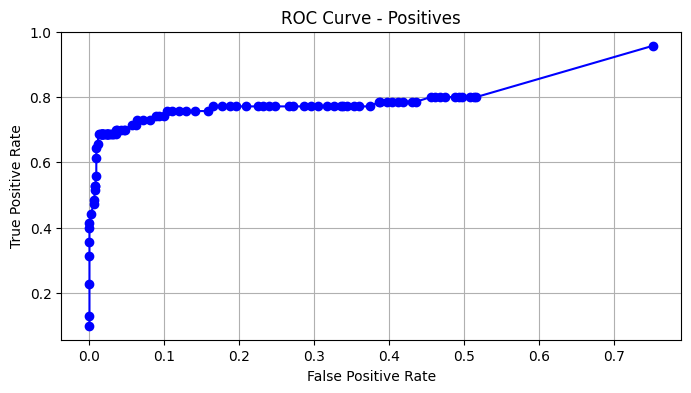

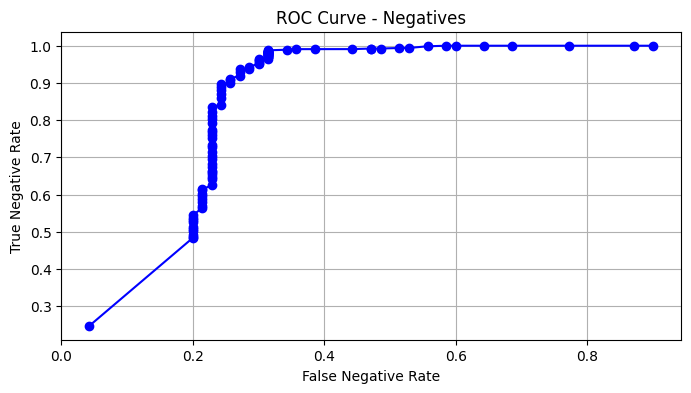

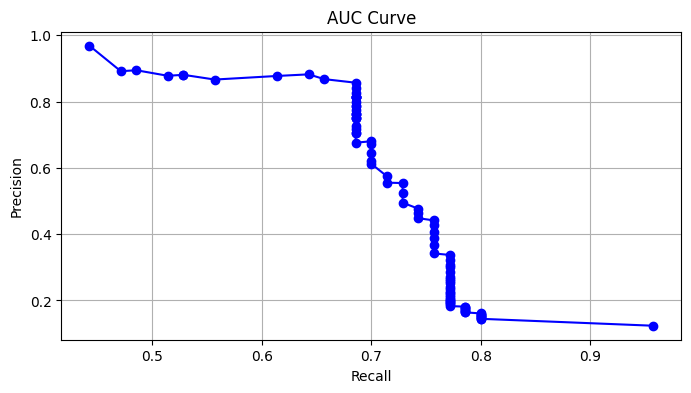

In [ ]:
tpr_list,fpr_list,tnr_list,fnr_list,precision_list,recall_list = [],[],[],[],[],[]
probability_list = np.linspace(0.1, 20, num=100, endpoint=True)
y_probability = None
y_recommended = None
context_before = 20
#print(probability_list)
for prob_th in probability_list:
  tpr,fpr,tnr,fnr,precision,recall,y_probability,y_recommended = get_roc_values(join(path_files,test_file),model,wtokenizer,prob_th,y_probability,y_recommended,config_file_loc=join(path_files,test_file_loc))
  tpr_list.append(tpr)
  fpr_list.append(fpr)
  tnr_list.append(tnr)
  fnr_list.append(fnr)
  precision_list.append(precision)
  recall_list.append(recall)

# Plotting ROC
plt.figure(figsize=(8, 4))
plt.plot(fpr_list, tpr_list, 'o-', color='blue')  # 'o-' creates circular markers connected by lines
plt.title("ROC Curve - Positives")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

# Plotting ROC
plt.figure(figsize=(8, 4))
plt.plot(fnr_list, tnr_list, 'o-', color='blue')  # 'o-' creates circular markers connected by lines
plt.title("ROC Curve - Negatives")
plt.xlabel("False Negative Rate")
plt.ylabel("True Negative Rate")
plt.grid(True)
plt.show()

# Plotting AUC
plt.figure(figsize=(8, 4))
plt.plot(recall_list, precision_list, 'o-', color='blue')  # 'o-' creates circular markers connected by lines
plt.title("AUC Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


##Test 3. Confusion matrix for the best performance

Accuracy:	 0.9828
Precision:	 0.8235
Recall:	 0.8000
F1 score:	 0.8116
False positives rate:	 0.0187
False negatives rate:	 0.2000


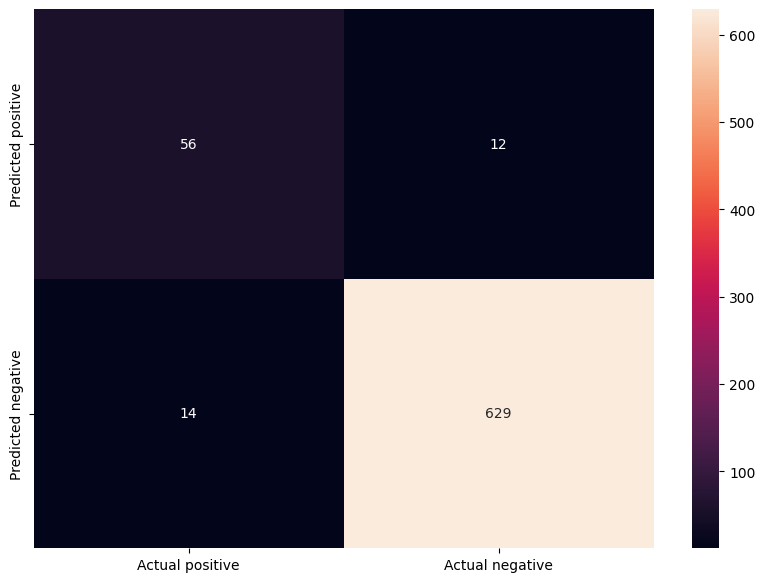

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
tp = 56
fp = 12
total = 697
p = total_positives
tn = total-tp-fp
fn = p-tp
n = total-p

array = [[tp,fp],
        [fn,tn]]
df_cm = pd.DataFrame(array, index = [i for i in ["Predicted positive","Predicted negative"]],
                  columns = ["Actual positive","Actual negative"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.0f')

# accuracy: (tp + tn) / (p + n)
accuracy = (tp+tn)/total
print('Accuracy:\t %.4f' % accuracy)
# precision tp / (tp + fp)
precision = tp / (tp+fp)
print('Precision:\t %.4f' % precision)
# recall: tp / (tp + fn)
recall = tp / (tp+fn)
print('Recall:\t %.4f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = 2*tp / (2*tp + fp + fn)
print('F1 score:\t %.4f' % f1)
# fpr: 2 tp / (2 tp + fp + fn)
fpr = fp / (tn+fp)
print('False positives rate:\t %.4f' % fpr)
# fnr: 2 tp / (2 tp + fp + fn)
fnr = fn / (tp+fn)
print('False negatives rate:\t %.4f' % fnr)